<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Mini Project 3

# Name: Mashukul Mustafa

## Import Libraries

In [1]:
## Import Libraries
import pandas as pd
import itertools
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn import model_selection

from sklearn.metrics import roc_curve, auc
from sklearn.datasets import make_classification

import warnings

# Necessary Functions:

In [2]:
def data_size_and_type(df): # shows size and data types
    print("Data Size:")
    print("number of rows:    ",df.shape[0])
    print("number of columns: ",df.shape[1])
    print("\nData Type:")
    print(df.dtypes)


def missing_value(df): # shows the number of missing values if any else shows no missing value
    if sum(df.isnull().sum())>0:
        print("Missing Values:")
        print(df.isnull().sum())
        print("\nMissing Values by Percentage:")
        df1=(df.isnull().sum().apply(lambda x:(x/df.shape[0]*100)))
        df1.plot(kind="bar")
        plt.show()
        print(df1.loc[df1>0.0].apply(lambda x: str(round(x,2))+"%"))
    else:
        print('No missing value found')

        
def number_of_outliers(df):#check outliers for all columns
    threshold = 3
    total_outliers={}
    for j in df.select_dtypes(include=np.number).columns:
        mean=df[j].mean()
        std=df[j].std()
        outlier = []
        for i in df[j]:
            z = abs(i-mean)/std
            if z > threshold:
                outlier.append(i)
        total_outliers[j]=len(outlier)
    return pd.Series(total_outliers)

def remove_outlier_base_on_IQR(df,feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    upper_limit = Q3 + 1.5 * IQR
    lower_limit = Q1 - 1.5 * IQR
    df[feature] = np.where(df[feature]>upper_limit,upper_limit,np.where(df[feature]<lower_limit,lower_limit,df[feature]))
    

def remove_outlier_based_on_z_value(df,feature):
    upper_limit = df[feature].mean() + 3*df[feature].std()
    lower_limit = df[feature].mean() - 3*df[feature].std()
    df[feature] = np.where(df[feature]>upper_limit,upper_limit,np.where(df[feature]<lower_limit,lower_limit,df[feature]))

def remove_outlier_with_median(df,feature):
    upper_limit = df[feature].mean() + 2.9*df[feature].std()
    lower_limit = df[feature].mean() - 2.9*df[feature].std()
    df[feature] = np.where(df[feature]>upper_limit,df[feature].median(),
                           np.where(df[feature]<lower_limit,df[feature].median(),df[feature]))



def salary_to_binary(amount):
    if amount==' >50K':
        return 1
    else:
        return 0

def encode_categorical(col_name):
    df.groupby([col_name])['Salary'].mean()

    Encoded_Lables = df.groupby([col_name])['Salary'].mean().sort_values().index

    Encoded_Lables_Ranks = { k:i for i, k in enumerate(Encoded_Lables, 0) }
    print(Encoded_Lables_Ranks)

    df[col_name] = df[col_name].map(Encoded_Lables_Ranks)
    return df

def grid_search_func(estimator, params, X_train, y_train, X_test, y_test, scoring_function=metrics.r2_score, scoring='r2', cv=5):
    gs = GridSearchCV(
        estimator=estimator,
        param_grid=params,
        return_train_score=True,
        scoring=scoring,
        cv = cv)

    gs.fit(X_train, y_train)

    print("Best score")
    print(gs.best_score_)
    print()
    print("Best estimator")
    print(gs.best_estimator_.get_params())
    print()

    predictions = gs.best_estimator_.predict(X_test)
    print('Test score: ', scoring_function(y_test, predictions))


    return gs

def evaluate(model,X,X_train, X_test, y, y_train, y_test):
    model.fit(X_train,y_train)
    y_pred_class_training = model.predict(X_train)
    training_accuracy_score=metrics.accuracy_score(y_train,y_pred_class_training)
    print("Training Accuracy Score:\n",training_accuracy_score )
    y_pred_class_test = model.predict(X_test)
    test_accuracy_score=metrics.accuracy_score(y_test,y_pred_class_test)
    print("Test Accuracy Score:\n", test_accuracy_score)
    
    print("confusion_matrix:\n",metrics.confusion_matrix(y_test, y_pred_class_test))
    print("classification_report:\n",metrics.classification_report(y_test, y_pred_class_test))
    return training_accuracy_score,test_accuracy_score

## Load data

In [3]:
# Read data in pandas
#df=pd.read_csv("miniproject3/adult.data",header=None)
df=pd.read_csv("adult.data",header=None, names=['age','workclass','fnlwgt','education',
                                                'education-num','marital-status','occupation', 
                                                'relationship','race','sex','capital-gain','capital-loss',
                                               'hours-per-week','native-country','Salary'])
# Check data has loaded correctly
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
data_size_and_type(df)

Data Size:
number of rows:     32561
number of columns:  15

Data Type:
age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
Salary            object
dtype: object


In [5]:
missing_value(df)

No missing value found


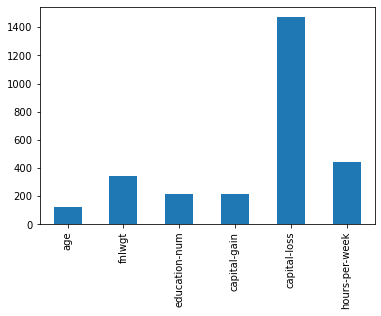

In [6]:
number_of_outliers(df).plot.bar()

In [7]:
for i in number_of_outliers(df).index:
    remove_outlier_with_median(df,i)


In [8]:
number_of_outliers(df)

age                 0
fnlwgt            144
education-num       0
capital-gain      938
capital-loss       45
hours-per-week    220
dtype: int64

In [9]:
for i in ["fnlwgt","hours-per-week"]:
    remove_outlier_base_on_IQR(df,i)

In [10]:
number_of_outliers(df)

age                 0
fnlwgt              0
education-num       0
capital-gain      938
capital-loss       45
hours-per-week      0
dtype: int64

## Feature Engineering

In [11]:
for i in df.select_dtypes(['object']).columns:
    print(i,len(set(df[i])))

workclass 9
education 16
marital-status 7
occupation 15
relationship 6
race 5
sex 2
native-country 42
Salary 2


In [12]:
df.loc[:, df.dtypes == 'object'] = df.select_dtypes(['object']).apply(lambda x: x.astype('category'))

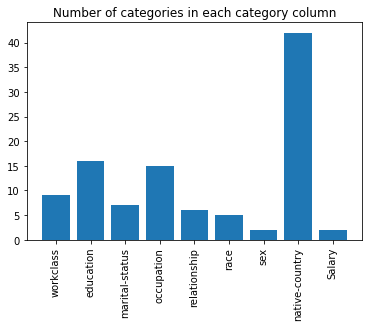

In [13]:
cat_features={}
for i in df.select_dtypes(['category']).columns:
    cat_features[i]=len(df[i].unique())
cat_features

import matplotlib.pyplot as plt



plt.bar(range(len(cat_features)), list(cat_features.values()), align='center')
plt.title("Number of categories in each category column")
plt.xticks(range(len(cat_features)), list(cat_features.keys()), rotation=90 )
plt.show()

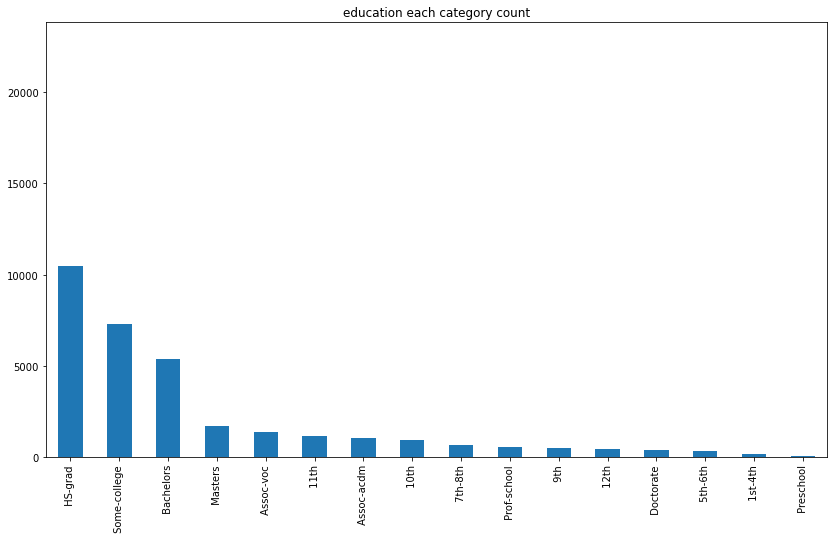

In [14]:
for i in df.select_dtypes(['category']).columns:
    ax = df[i].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="%s each category count"%i)
    if i =="education":
        break



In [15]:
df['Salary']=df['Salary'].cat.codes
#df['Salary']=df['Salary'].apply(salary_to_binary)

In [16]:
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Salary
0,39.0,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,0
1,50.0,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,32.5,United-States,0
2,38.0,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,0
3,53.0,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,0
4,28.0,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27.0,Private,257302.0,Assoc-acdm,12.0,Married-civ-spouse,Tech-support,Wife,White,Female,0.0,0.0,38.0,United-States,0
32557,40.0,Private,154374.0,HS-grad,9.0,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,40.0,United-States,1
32558,58.0,Private,151910.0,HS-grad,9.0,Widowed,Adm-clerical,Unmarried,White,Female,0.0,0.0,40.0,United-States,0
32559,22.0,Private,201490.0,HS-grad,9.0,Never-married,Adm-clerical,Own-child,White,Male,0.0,0.0,32.5,United-States,0


In [17]:
df.dtypes

age                float64
workclass         category
fnlwgt             float64
education         category
education-num      float64
marital-status    category
occupation        category
relationship      category
race              category
sex               category
capital-gain       float64
capital-loss       float64
hours-per-week     float64
native-country    category
Salary                int8
dtype: object

In [18]:
col_to_encode=['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'native-country']
for i in col_to_encode:
    df=encode_categorical(i)

{' Never-worked': 0, ' Without-pay': 1, ' ?': 2, ' Private': 3, ' State-gov': 4, ' Self-emp-not-inc': 5, ' Local-gov': 6, ' Federal-gov': 7, ' Self-emp-inc': 8}
{' Preschool': 0, ' 1st-4th': 1, ' 5th-6th': 2, ' 11th': 3, ' 9th': 4, ' 7th-8th': 5, ' 10th': 6, ' 12th': 7, ' HS-grad': 8, ' Some-college': 9, ' Assoc-acdm': 10, ' Assoc-voc': 11, ' Bachelors': 12, ' Masters': 13, ' Prof-school': 14, ' Doctorate': 15}
{' Never-married': 0, ' Separated': 1, ' Married-spouse-absent': 2, ' Widowed': 3, ' Divorced': 4, ' Married-AF-spouse': 5, ' Married-civ-spouse': 6}
{' Priv-house-serv': 0, ' Other-service': 1, ' Handlers-cleaners': 2, ' ?': 3, ' Armed-Forces': 4, ' Farming-fishing': 5, ' Machine-op-inspct': 6, ' Adm-clerical': 7, ' Transport-moving': 8, ' Craft-repair': 9, ' Sales': 10, ' Tech-support': 11, ' Protective-serv': 12, ' Prof-specialty': 13, ' Exec-managerial': 14}
{' Own-child': 0, ' Other-relative': 1, ' Unmarried': 2, ' Not-in-family': 3, ' Husband': 4, ' Wife': 5}
{' Other': 0,

In [19]:
a={' Preschool': 0, ' 1st-4th': 1, ' 5th-6th': 2, ' 11th': 3, ' 9th': 4, ' 7th-8th': 5, ' 10th': 6, ' 12th': 7, ' HS-grad': 8, ' Some-college': 9, ' Assoc-acdm': 10, ' Assoc-voc': 11, ' Bachelors': 12, ' Masters': 13, ' Prof-school': 14, ' Doctorate': 15}
print("Education:\n")
for i in a.items():
    print(i[0],i[1])

Education:

 Preschool 0
 1st-4th 1
 5th-6th 2
 11th 3
 9th 4
 7th-8th 5
 10th 6
 12th 7
 HS-grad 8
 Some-college 9
 Assoc-acdm 10
 Assoc-voc 11
 Bachelors 12
 Masters 13
 Prof-school 14
 Doctorate 15


In [20]:
df['Salary']=df['Salary'].astype('category')

In [21]:
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Salary
0,39.0,4,77516.0,12,13.0,0,7,3,3,Male,2174.0,0.0,40.0,23,0
1,50.0,5,83311.0,12,13.0,6,14,4,3,Male,0.0,0.0,32.5,23,0
2,38.0,3,215646.0,8,9.0,4,2,3,3,Male,0.0,0.0,40.0,23,0
3,53.0,3,234721.0,3,7.0,6,2,4,2,Male,0.0,0.0,40.0,23,0
4,28.0,3,338409.0,12,13.0,6,13,5,2,Female,0.0,0.0,40.0,26,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27.0,3,257302.0,10,12.0,6,11,5,3,Female,0.0,0.0,38.0,23,0
32557,40.0,3,154374.0,8,9.0,6,6,4,3,Male,0.0,0.0,40.0,23,1
32558,58.0,3,151910.0,8,9.0,3,7,2,3,Female,0.0,0.0,40.0,23,0
32559,22.0,3,201490.0,8,9.0,0,7,0,3,Male,0.0,0.0,32.5,23,0


In [22]:
df.sex.unique()

[' Male', ' Female']
Categories (2, object): [' Male', ' Female']

In [23]:
df['sex'] = df['sex'].map({' Male': 0,' Female': 1})

In [24]:
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Salary
0,39.0,4,77516.0,12,13.0,0,7,3,3,0,2174.0,0.0,40.0,23,0
1,50.0,5,83311.0,12,13.0,6,14,4,3,0,0.0,0.0,32.5,23,0
2,38.0,3,215646.0,8,9.0,4,2,3,3,0,0.0,0.0,40.0,23,0
3,53.0,3,234721.0,3,7.0,6,2,4,2,0,0.0,0.0,40.0,23,0
4,28.0,3,338409.0,12,13.0,6,13,5,2,1,0.0,0.0,40.0,26,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27.0,3,257302.0,10,12.0,6,11,5,3,1,0.0,0.0,38.0,23,0
32557,40.0,3,154374.0,8,9.0,6,6,4,3,0,0.0,0.0,40.0,23,1
32558,58.0,3,151910.0,8,9.0,3,7,2,3,1,0.0,0.0,40.0,23,0
32559,22.0,3,201490.0,8,9.0,0,7,0,3,0,0.0,0.0,32.5,23,0


In [25]:
df.dtypes

age                float64
workclass         category
fnlwgt             float64
education         category
education-num      float64
marital-status    category
occupation        category
relationship      category
race              category
sex               category
capital-gain       float64
capital-loss       float64
hours-per-week     float64
native-country    category
Salary            category
dtype: object

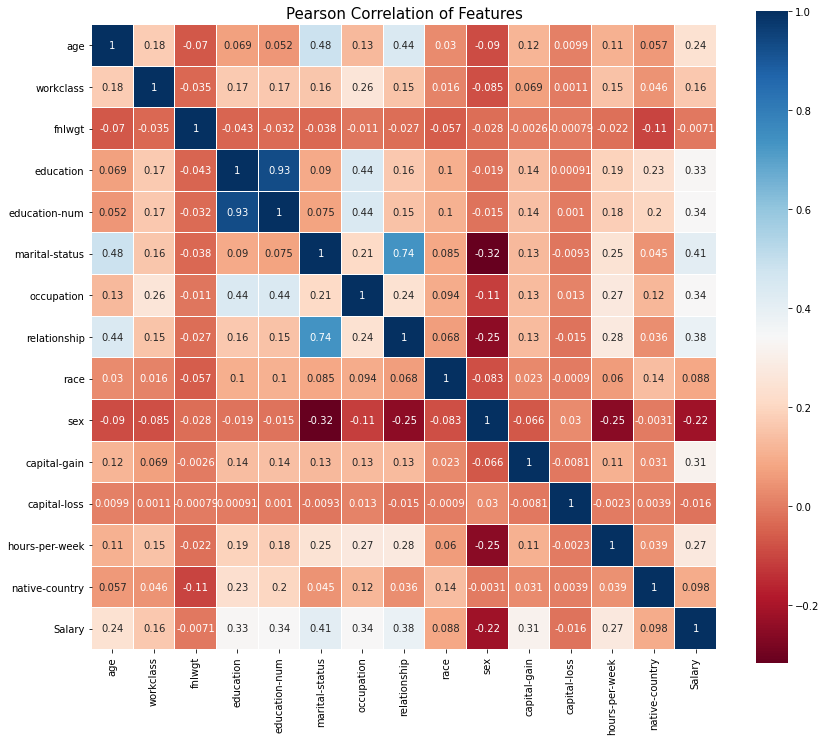

In [26]:
colormap = plt.cm.RdBu
plt.figure(figsize = (14, 12))
plt.title('Pearson Correlation of Features', size = 15)
sns.heatmap(df.astype(float).corr(),
            linewidths = 0.1,
            vmax = 1.0,
            square = True,
            cmap = colormap,
            linecolor = 'white',
            annot = True)
plt.show()

In [27]:
df.drop(['education', 'relationship'], axis=1, inplace=True)

In [28]:
# initial screening: how features relates to Salary

df.corr()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
age,1.000000,-0.070107,0.052462,0.118723,0.009925,0.106043
fnlwgt,-0.070107,1.000000,-0.032194,-0.002590,-0.000788,-0.022325
education-num,0.052462,-0.032194,1.000000,0.142330,0.001037,0.181189
capital-gain,0.118723,-0.002590,0.142330,1.000000,-0.008150,0.105167
capital-loss,0.009925,-0.000788,0.001037,-0.008150,1.000000,-0.002296
hours-per-week,0.106043,-0.022325,0.181189,0.105167,-0.002296,1.000000


In [29]:
target="Salary"
X=df[[i for i in df.columns if i !=target]]
#X=pd.get_dummies(X).to_numpy()
#y=df[target].to_numpy()
y=df[target]
df.dtypes


age                float64
workclass         category
fnlwgt             float64
education-num      float64
marital-status    category
occupation        category
race              category
sex               category
capital-gain       float64
capital-loss       float64
hours-per-week     float64
native-country    category
Salary            category
dtype: object

In [30]:
# Create an instance of SelectKBest
kbest=SelectKBest(score_func=chi2,k=9)
# Fit 
fit=kbest.fit(X,y)

pd.DataFrame(fit.scores_,index=X.columns,columns=["values"]).sort_values(by='values')["values"].apply(lambda x: '%.3f' % x)

race                    20.197
native-country         213.578
workclass              472.822
sex                   1016.447
hours-per-week        2112.533
education-num         2237.112
capital-loss          6834.924
occupation            7814.351
age                   8825.569
marital-status       11420.808
fnlwgt               74075.825
capital-gain      30728353.877
Name: values, dtype: object

In [31]:
f = kbest.get_support(1)
X_new = X[X.columns[f]] # final features`
X_new.columns

Index(['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week'],
      dtype='object')

In [32]:
# ANSWER
model=LogisticRegression(max_iter=5000)
rfe=RFE(estimator=model,n_features_to_select=10)
fit=rfe.fit(X,y)
#number of features, selected features, ranking
fit.n_features_,fit.support_,fit.ranking_

(10,
 array([ True,  True, False,  True,  True,  True,  True,  True, False,
         True,  True,  True]),
 array([1, 1, 3, 1, 1, 1, 1, 1, 2, 1, 1, 1]))

In [33]:
# Print Score 
# Find Features
pd.DataFrame(fit.support_, index=X.columns, columns=["Status"])

,Status
age,True
workclass,True
fnlwgt,False
education-num,True
marital-status,True
occupation,True
race,True
sex,True
capital-gain,False
capital-loss,True


In [34]:
#df.drop(['capital-gain','fnlwgt'], axis=1, inplace=True)
df.drop(['race','native-country'], axis=1, inplace=True)
X=df[[i for i in df.columns if i !=target]]

## Modelling

In [35]:
len(df[df.Salary==1]),len(df[df.Salary==0])

(7841, 24720)

In [36]:
len(df[df.Salary==0])/len(df)

0.7591904425539756

In [37]:
results=pd.DataFrame(columns=["Model","training_Accuracy","test_Accuracy"])

In [38]:
results

,Model,training_Accuracy,test_Accuracy


In [39]:
# Split your data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

In [40]:
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import MinMaxScaler

scaler=StandardScaler()

X_train, X_test = scaler.fit_transform(X_train),scaler.transform(X_test)

# GaussianNB

In [41]:
model=GaussianNB()
train_score, test_score= evaluate(model,X,X_train,X_test, y, y_train, y_test)

d = {'Model': "GaussianNB", 'training_Accuracy':train_score,'test_Accuracy': test_score}

results=results.append(pd.DataFrame(d,index=[len(results)+1]))

Training Accuracy Score:
 0.8156565656565656
Test Accuracy Score:
 0.817009517961314
confusion_matrix:
 [[2122  334]
 [ 262  539]]
classification_report:
               precision    recall  f1-score   support

           0       0.89      0.86      0.88      2456
           1       0.62      0.67      0.64       801

    accuracy                           0.82      3257
   macro avg       0.75      0.77      0.76      3257
weighted avg       0.82      0.82      0.82      3257



In [42]:
results

,Model,training_Accuracy,test_Accuracy
1,GaussianNB,0.815657,0.81701


In [43]:
train_score, test_score

(0.8156565656565656, 0.817009517961314)

## Logistic regression

In [44]:
from sklearn.linear_model import LogisticRegression
model=LogisticRegression(max_iter=5000)
train_score, test_score= evaluate(model,X,X_train,X_test, y, y_train, y_test)
d = {'Model': "Logistic regression", 'training_Accuracy':train_score,'test_Accuracy': test_score}

results=results.append(pd.DataFrame(d,index=[len(results)+1]))

Training Accuracy Score:
 0.8395440895440895
Test Accuracy Score:
 0.8498618360454406
confusion_matrix:
 [[2308  148]
 [ 341  460]]
classification_report:
               precision    recall  f1-score   support

           0       0.87      0.94      0.90      2456
           1       0.76      0.57      0.65       801

    accuracy                           0.85      3257
   macro avg       0.81      0.76      0.78      3257
weighted avg       0.84      0.85      0.84      3257



## KNN

In [45]:
from sklearn.neighbors import KNeighborsClassifier


neigh = KNeighborsClassifier(n_neighbors=24)
train_score, test_score= evaluate(neigh,X,X_train,X_test, y, y_train, y_test)
d = {'Model': "KNN", 'training_Accuracy':train_score,'test_Accuracy': test_score}

results=results.append(pd.DataFrame(d,index=[len(results)+1]))

Training Accuracy Score:
 0.85500273000273
Test Accuracy Score:
 0.8480196499846484
confusion_matrix:
 [[2304  152]
 [ 343  458]]
classification_report:
               precision    recall  f1-score   support

           0       0.87      0.94      0.90      2456
           1       0.75      0.57      0.65       801

    accuracy                           0.85      3257
   macro avg       0.81      0.75      0.78      3257
weighted avg       0.84      0.85      0.84      3257



In [ ]:
knn_params = {
    'n_neighbors': [4,5,6]
}

model=KNeighborsClassifier()
gs_knn = grid_search_func(model, knn_params,X_train, y_train, X_test, y_test)

## GridSearch KNN

In [ ]:
#List Hyperparameters that we want to tune.
leaf_size = list(range(1,50))
n_neighbors = list(range(1,30))
p=[1,2]
#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
#Create new KNN object
knn_2 = KNeighborsClassifier()
#Use GridSearch
clf = GridSearchCV(knn_2, hyperparameters, cv=10)
#Fit the model
best_model = clf.fit(X,y)
#Print The value of best Hyperparameters
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

# SVC

In [ ]:
model_rbf = SVC(kernel='rbf')
train_score, test_score= evaluate(model_rbf,X,X_train,X_test, y, y_train, y_test)
d = {'Model': "SVC", 'training_Accuracy':train_score,'test_Accuracy': test_score}
results=results.append(pd.DataFrame(d,index=[len(results)+1]))

In [ ]:
svc_params = {
    'C': [1, 10, 100],
    'gamma': [0.001, 0.0001],
    'kernel': ['linear','rbf']
}

model=SVC()
gs_svc = grid_search_func(model, svc_params,X_train, y_train, X_test, y_test)

# decision Tree

In [ ]:
model = DecisionTreeClassifier(random_state=0,max_depth= 9)
train_score, test_score= evaluate(model,X,X_train,X_test, y, y_train, y_test)
d = {'Model': "Decision Tree", 'training_Accuracy':train_score,'test_Accuracy': test_score}
results=results.append(pd.DataFrame(d,index=[len(results)+1]))


In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(model, X, y, cv=10)

In [ ]:
dt_params = {
    'max_depth': [8,9,10,11,12]
}

model=DecisionTreeClassifier()
gs_dt = grid_search_func(model, dt_params,X_train, y_train, X_test, y_test)

## Random forest

In [ ]:

clf = RandomForestClassifier( max_depth=11,n_estimators=50, random_state=0)
train_score, test_score= evaluate(clf,X,X_train,X_test, y, y_train, y_test)
d = {'Model': "Random Forest", 'training_Accuracy':train_score,'test_Accuracy': test_score}
results=results.append(pd.DataFrame(d,index=[len(results)+1]))


In [ ]:
rf_params = {
    'max_depth': [8,9,10,11,12]
}

model=RandomForestClassifier()
gs_rf = grid_search_func(model, rf_params,X_train, y_train, X_test, y_test)

## Stacking

In [ ]:

estimators = [('rf', RandomForestClassifier(max_depth=12,n_estimators=50, random_state=0)),
              ('knn', KNeighborsClassifier(n_neighbors=5)),
              ('svc', make_pipeline(StandardScaler(),
                         SVC(kernel='rbf',random_state=42)))]

clf = StackingClassifier(estimators=estimators, cv=10, final_estimator=LogisticRegression())


train_score, test_score= evaluate(clf,X,X_train,X_test, y, y_train, y_test)
d = {'Model': "Stacking", 'training_Accuracy':train_score,'test_Accuracy': test_score}
results=results.append(pd.DataFrame(d,index=[len(results)+1]))

## Presenting results

In [ ]:


# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = clf.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

In [ ]:
results

## Grid Search and Cross Validation (Stacking)

In [ ]:
from mlxtend.classifier import StackingCVClassifier
from mlxtend.classifier import StackingClassifier
# Initializing models

clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf1, clf2, clf3], 
                          meta_classifier=lr)

params = {'kneighborsclassifier-1__n_neighbors': [1, 5],
          'kneighborsclassifier-2__n_neighbors': [1, 5],
          'randomforestclassifier__n_estimators': [10, 50],
          'meta_classifier__C': [0.1, 10.0]}

grid = GridSearchCV(estimator=sclf, 
                    param_grid=params, 
                    cv=5,
                    refit=True)
grid.fit(X, y)

cv_keys = ('mean_test_score', 'std_test_score', 'params')

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_[cv_keys[0]][r],
             grid.cv_results_[cv_keys[1]][r] / 2.0,
             grid.cv_results_[cv_keys[2]][r]))

print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

In [ ]:
warnings.simplefilter('ignore')

clf1 = KNeighborsClassifier(n_neighbors=6)
clf2 = RandomForestClassifier(max_depth=12,n_estimators=10, random_state=42)
clf3 = SVC(kernel='rbf',random_state=42)
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], 
                          meta_classifier=lr)

print('5-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, sclf], 
                      ['KNN', 
                       'Random Forest', 
                       'SVC',
                       'StackingClassifier']):

    scores = model_selection.cross_val_score(clf, X, y, 
                                              cv=5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

>

>

>



---



---



> > > > > > > > > © 2022 Institute of Data


---



---



